In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 20
CHANNELS = 3
EPOCHS = 20
n_classes = 2
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\DataTrained\Practice Data Samples\CNN\Malaria',
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6001 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Parasite', 'Uninfected']

In [6]:
len(dataset)

301

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(20, 256, 256, 3)
[0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0]


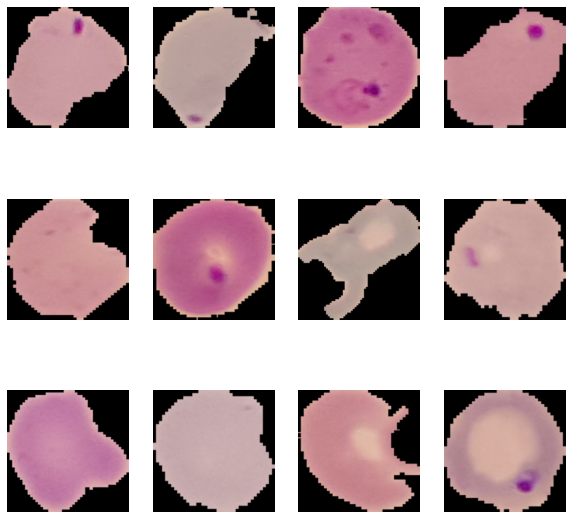

In [8]:
# First image
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        
    
# Without using .astype('uint8'), we will get a black and white image.

In [9]:
len(dataset)

301

### Splitting the dataset

In [10]:
# Same thing as done above, but as a function

def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [12]:
len(train_ds), len(val_ds), len(test_ds)

(240, 30, 31)

### Caching

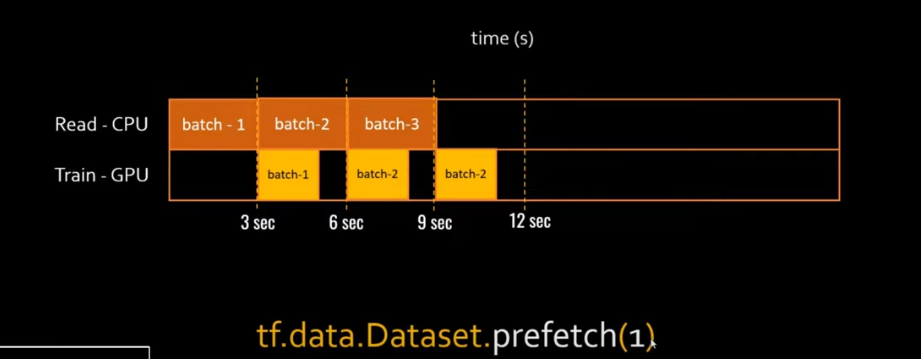|

In [13]:
# This will read image from disk and store it for next iteration and improves perfomance
# prefetch() will load the next batch size just incase the GPU is busy training


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resizing

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [15]:
# This is to make the model robust, just in case the image is inverted/different contrast etc.

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


### Convolution

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
    
])

model.build(input_shape = INPUT_SHAPE)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (20, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (20, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (20, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (20, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (20, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (20, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (20, 60, 60, 64)         

In [18]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
              metrics = ['accuracy'])

In [19]:
history = model.fit(train_ds, 
         epochs = EPOCHS, 
         batch_size = BATCH_SIZE, 
         verbose = 1, 
         validation_data = val_ds
         )

Epoch 1/20
240/240 [==============================] - 99s 281ms/step - loss: 0.4956 - accuracy: 0.7300 - val_loss: 0.2236 - val_accuracy: 0.9283
Epoch 2/20
240/240 [==============================] - 31s 123ms/step - loss: 0.2160 - accuracy: 0.9323 - val_loss: 0.2155 - val_accuracy: 0.9300
Epoch 3/20
240/240 [==============================] - 13s 54ms/step - loss: 0.1874 - accuracy: 0.9425 - val_loss: 0.1909 - val_accuracy: 0.9367
Epoch 4/20
240/240 [==============================] - 13s 54ms/step - loss: 0.1873 - accuracy: 0.9435 - val_loss: 0.2210 - val_accuracy: 0.9250
Epoch 5/20
240/240 [==============================] - 14s 57ms/step - loss: 0.1820 - accuracy: 0.9417 - val_loss: 0.1818 - val_accuracy: 0.9450
Epoch 6/20
240/240 [==============================] - 13s 54ms/step - loss: 0.1732 - accuracy: 0.9446 - val_loss: 0.1851 - val_accuracy: 0.9417
Epoch 7/20
240/240 [==============================] - 13s 53ms/step - loss: 0.1753 - accuracy: 0.9429 - val_loss: 0.1646 - val_accurac

In [20]:
scores = model.evaluate(test_ds)

31/31 [==============================] - 19s 27ms/step - loss: 0.1432 - accuracy: 0.9581


In [21]:
scores

[0.14321279525756836, 0.9580644965171814]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 240}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['accuracy']

[0.7300000190734863,
 0.9322916865348816,
 0.9424999952316284,
 0.9435416460037231,
 0.9416666626930237,
 0.9445833563804626,
 0.9429166913032532,
 0.9466666579246521,
 0.9414583444595337,
 0.9479166865348816,
 0.9460416436195374,
 0.9454166889190674,
 0.9464583396911621,
 0.9474999904632568,
 0.9447916746139526,
 0.9481250047683716,
 0.9466666579246521,
 0.9472916722297668,
 0.9456250071525574,
 0.9460416436195374]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

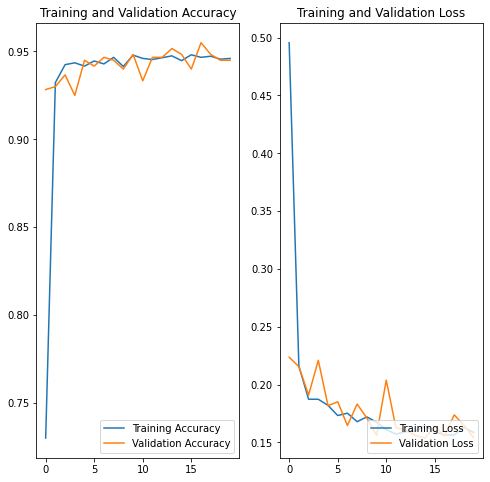

In [27]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

Parasite


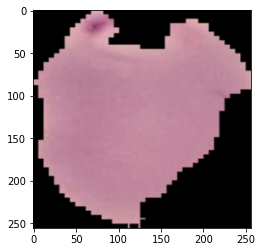

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[0].numpy().astype('uint8'))
    
    prediction = model.predict(images_batch)
    print(class_names[np.argmax(prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    prediction = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])), 2)
    return predicted_class, confidence

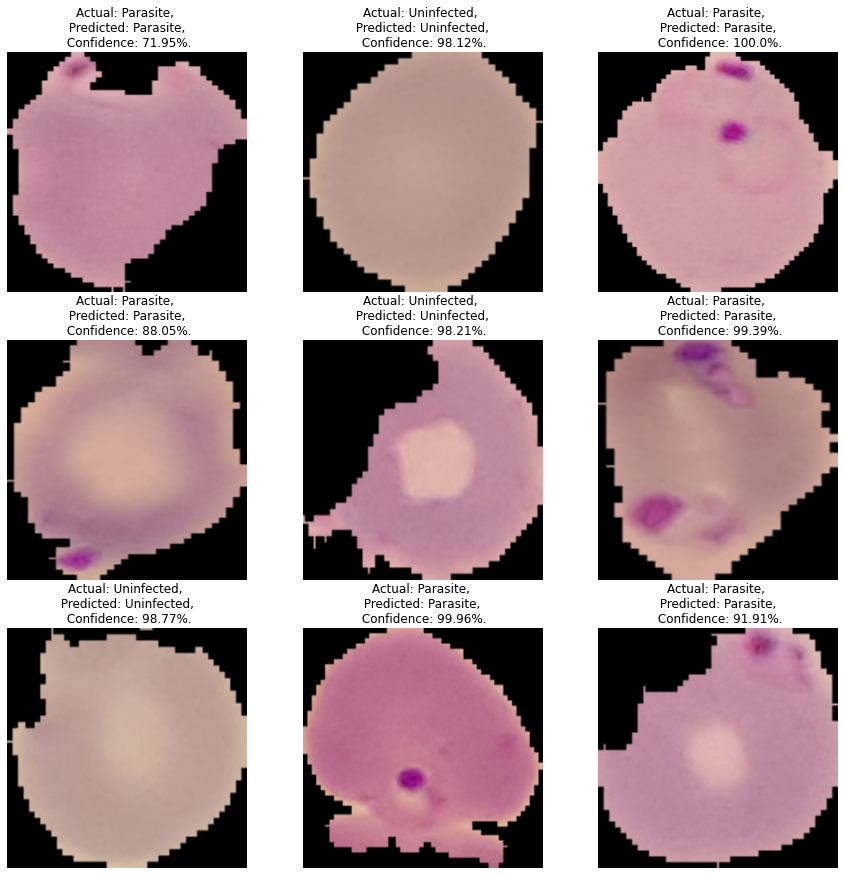

In [30]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%.')

In [31]:
model.save(f'../Models/MalariaDetection_CNN_Model.h5')

In [ ]:
# There seems to be an issue with tensorflow 2.7.0 where models which uses data augmentation can't be saved without explicitly mentioning it to be saved as an older h5 type file

# model_version = 1
# model.save(f'../Models/MalariaDetection_CNN_Model.h5')
# Used custom CNN Model to train.

#model_version = 2
#model.save(f'../Models/{model_version}')